In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import stackview
from skimage import io

from cell_interactome.config import parse_config
from cell_interactome.utils.inference.instance_seg_utils import (
    exclude_outliers,
    get_track_features,
    outlier_utils,
)
from cell_interactome.utils.tracking.tracking_utils import (
    create_velocity_predictor,
    filter_tracks,
    get_file_paths,
    load_centroids,
    plot_particle_freq,
    plot_timepoints,
    postprocess_tracking,
    sample_centroids,
)
from cell_interactome.utils.utils import PCA

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["axes.facecolor"] = "black"
plt.rcParams["figure.facecolor"] = "black"

In [2]:
n_components = 3
adaptive_step = 0.95
config = parse_config(
    config_path="/nfs/scratch1/ajain/cell_interactome/src/cell_interactome/config/inference.yaml"
)
# BASE_DIR = Path("/raid1/cme_tests/results/zeiss_488_ex4")
# BASE_DIR = Path("/raid1/cme_tests/results/zeiss_642_ex4")
BASE_DIR = Path("/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/")
file_paths = get_file_paths(BASE_DIR)
file_paths

[PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0000_488nm_0000000msec_0087860321msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0001_488nm_0003195msec_0087863516msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0002_488nm_0006390msec_0087866711msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0003_488nm_0009585msec_0087869906msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0004_488nm_0012780msec_0087873101msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0005_488nm_0015975msec_0087876296msecAbs_000x_000y_000z_0000t'),
 PosixPath('/nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0006_488nm_0019170msec_0087879491msecAbs_000x_000y_000z_0000t'),

Plotting 0 of 99
Plotting 19 of 99
Plotting 38 of 99
Plotting 57 of 99
Plotting 76 of 99
Plotting 95 of 99


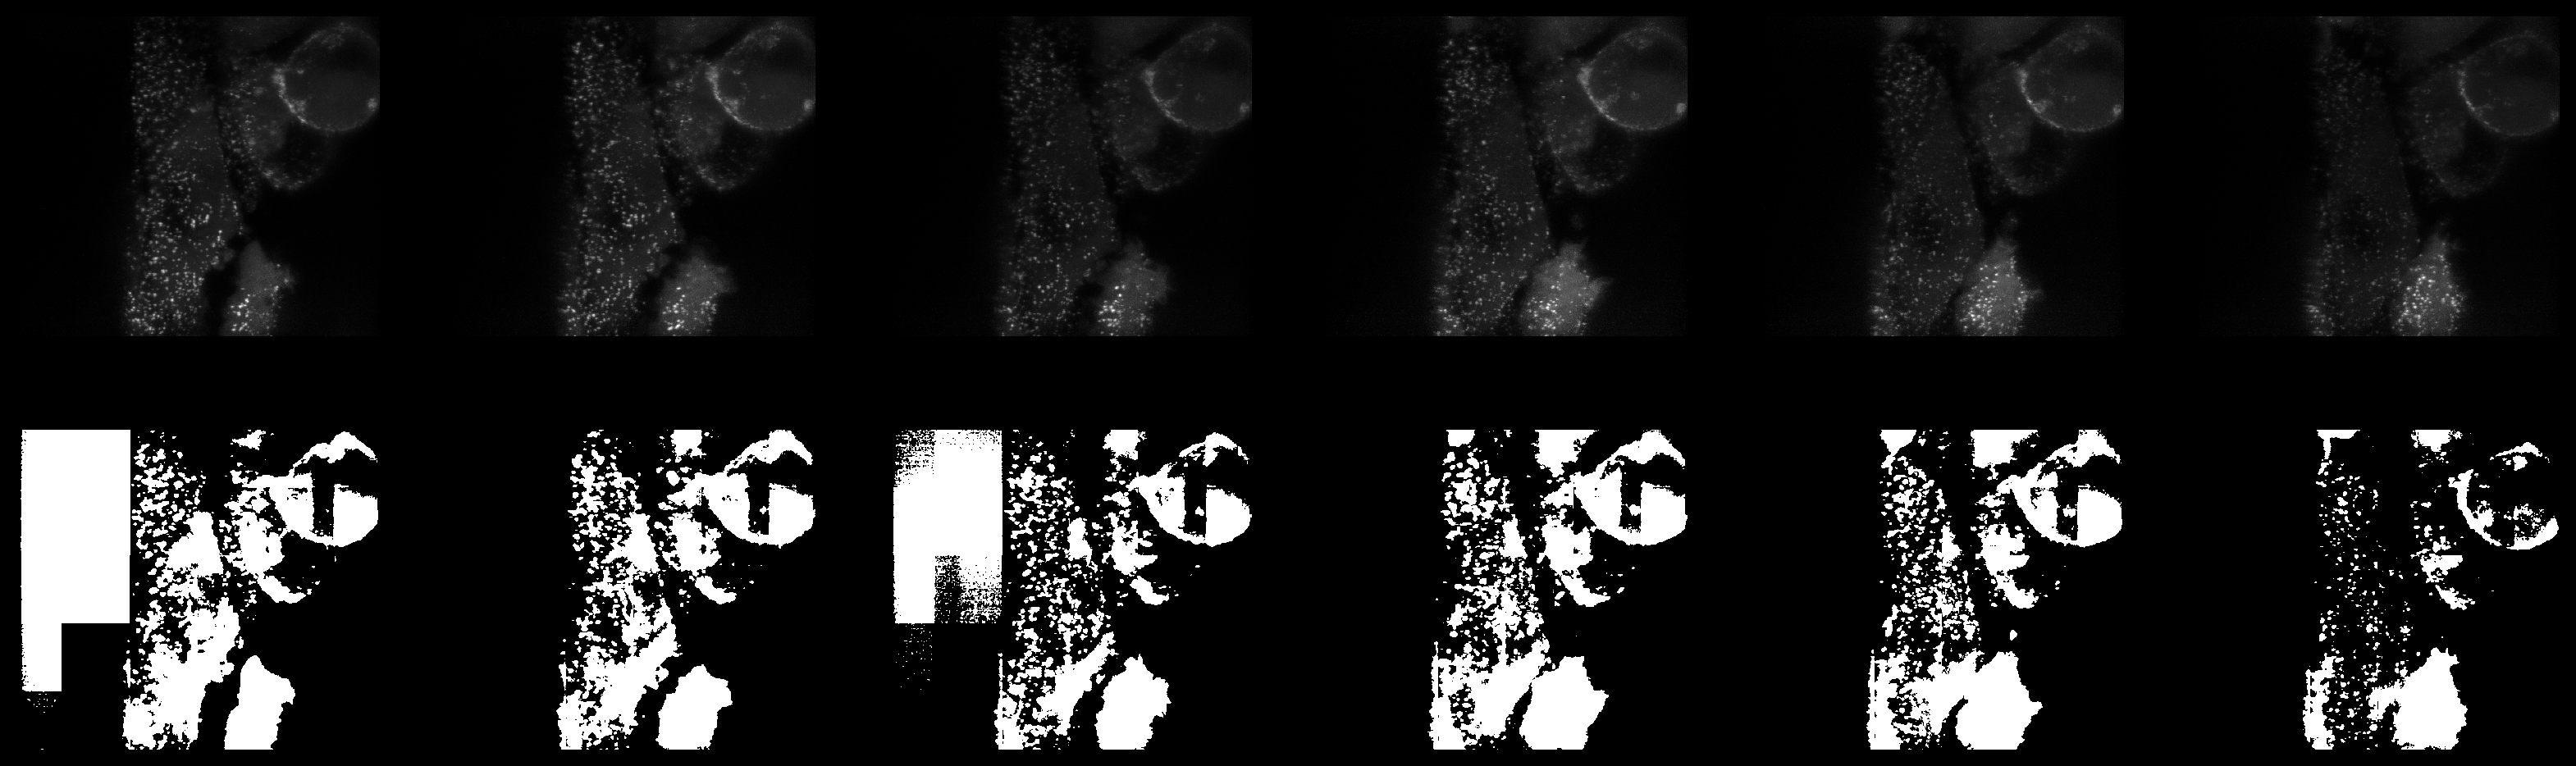

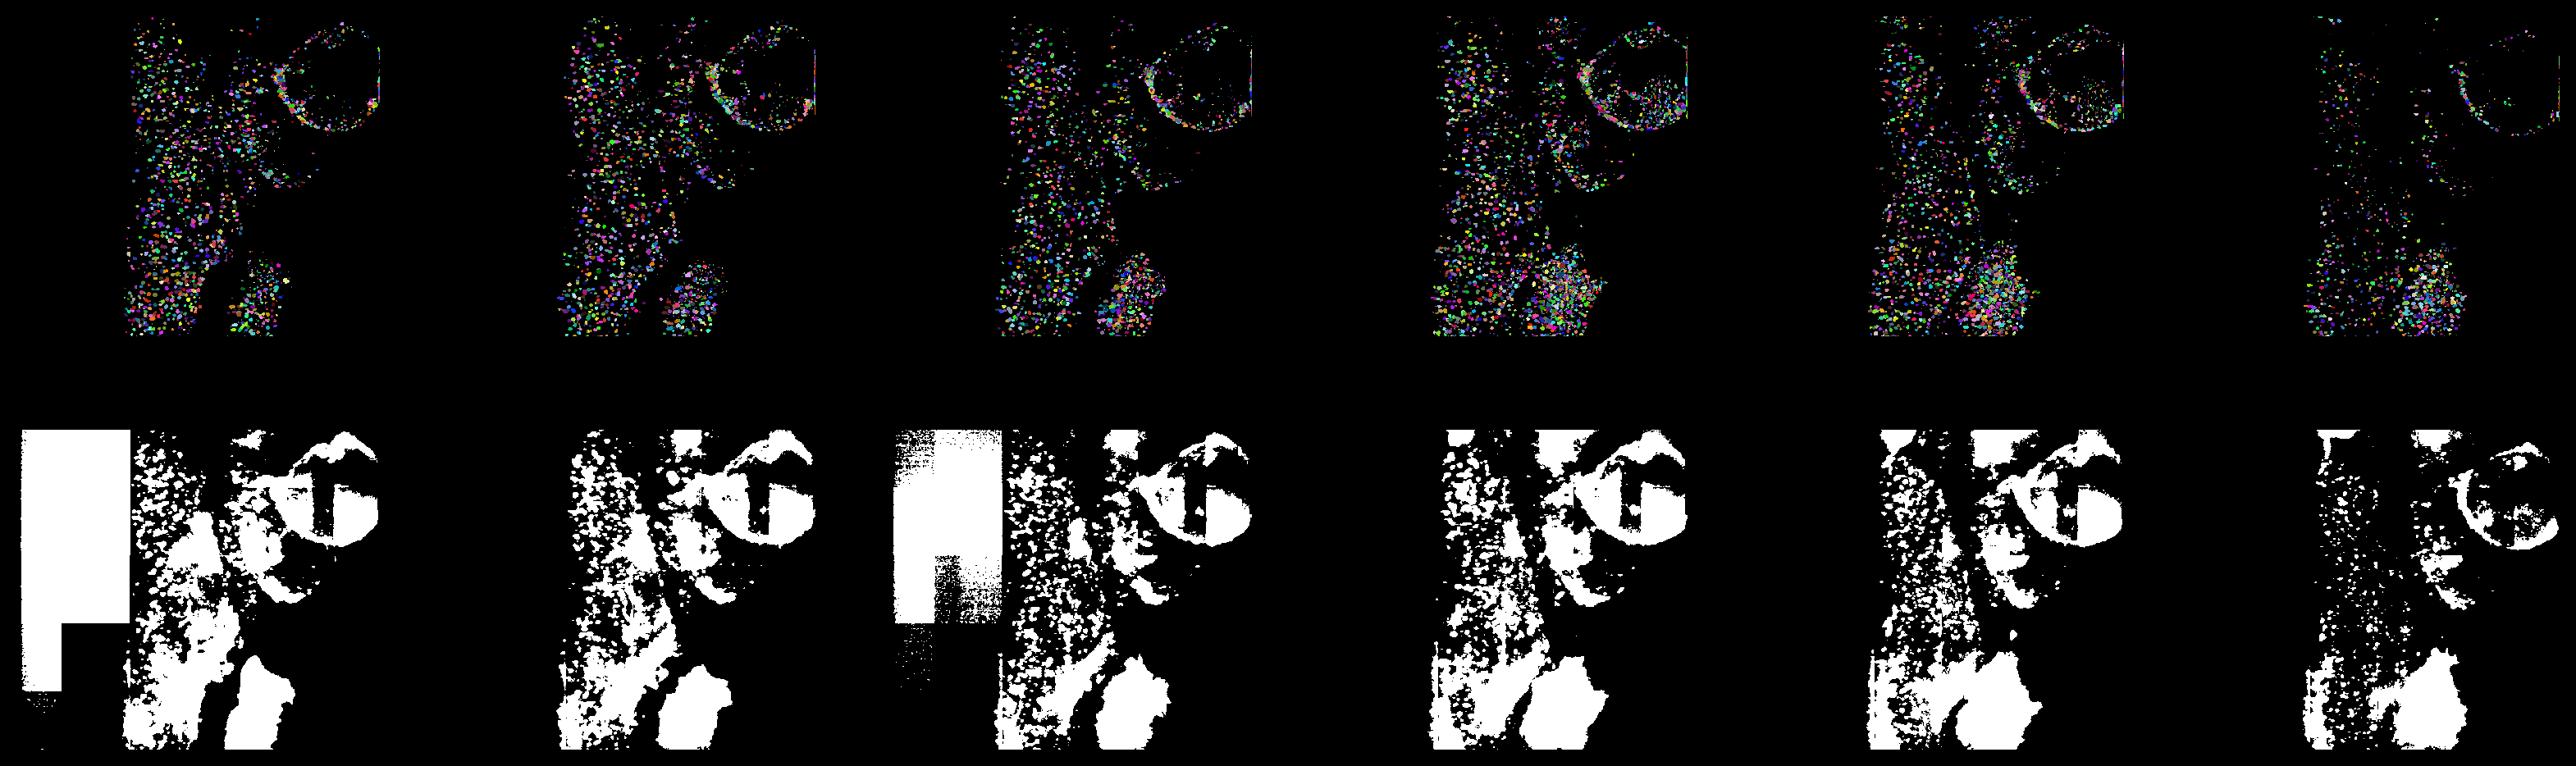

In [3]:
plot_timepoints(file_paths, type="raw")
plot_timepoints(file_paths, type="instance")

{0: 1709, 1: 1860, 2: 1565, 3: 1528, 4: 1821, 5: 1591, 6: 1621, 7: 1847, 8: 1814, 9: 1701, 10: 1926, 11: 1654, 12: 1752, 13: 2004, 14: 1882, 15: 1849, 16: 1760, 17: 1960, 18: 2048, 19: 1816, 20: 1689, 21: 1773, 22: 1974, 23: 1702, 24: 1595, 25: 1747, 26: 1567, 27: 1629, 28: 1457, 29: 1811, 30: 1857, 31: 1700, 32: 1504, 33: 1861, 34: 1868, 35: 1794, 36: 1922, 37: 2086, 38: 1797, 39: 1614, 40: 1855, 41: 2041, 42: 1741, 43: 1733, 44: 1572, 45: 1760, 46: 1776, 47: 2133, 48: 2165, 49: 1667, 50: 1722, 51: 1962, 52: 2328, 53: 2350, 54: 2074, 55: 2433, 56: 2724, 57: 2787, 58: 2848, 59: 2341, 60: 2770, 61: 2052, 62: 2460, 63: 2143, 64: 2175, 65: 2230, 66: 2397, 67: 2859, 68: 2676, 69: 2577, 70: 2998, 71: 2158, 72: 2245, 73: 2336, 74: 2278, 75: 2080, 76: 2395, 77: 1996, 78: 1822, 79: 2166, 80: 1945, 81: 1590, 82: 1767, 83: 1529, 84: 1631, 85: 1382, 86: 1383, 87: 1135, 88: 1428, 89: 1266, 90: 1391, 91: 1310, 92: 1631, 93: 1368, 94: 1157, 95: 1064, 96: 1102, 97: 1563, 98: 1178}
Min: 1064, Max: 299

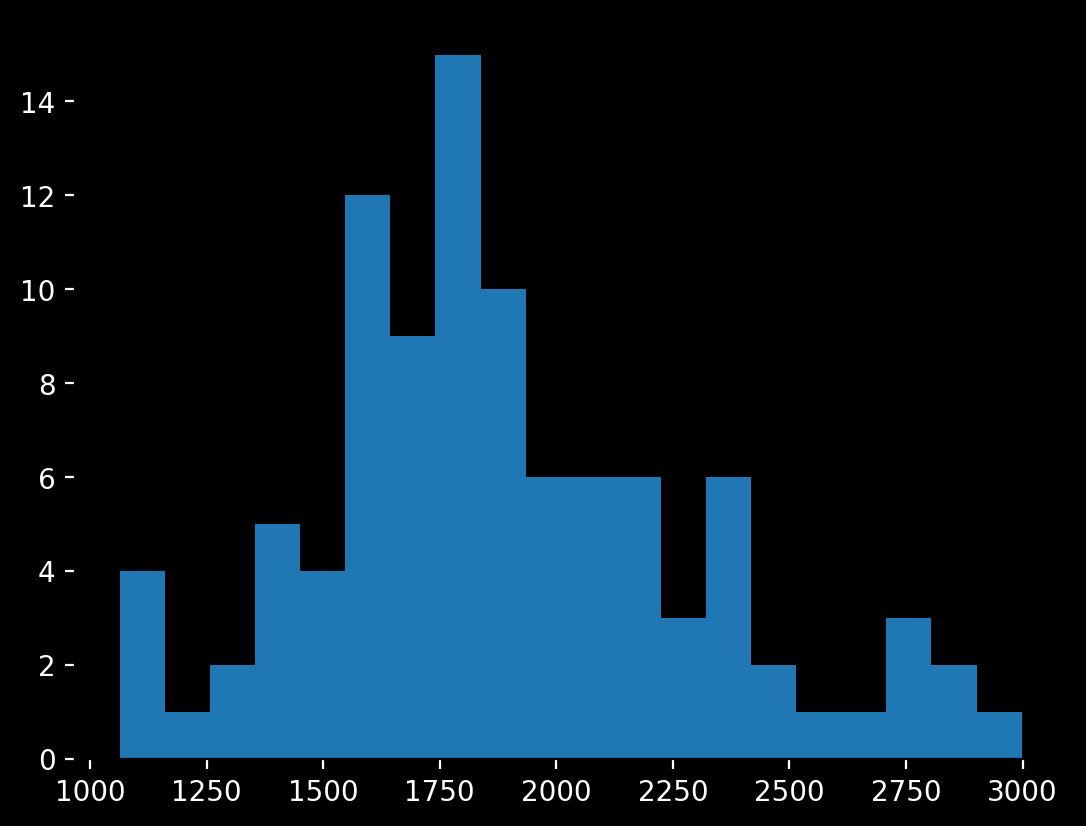

In [4]:
centroids, detections, min_detections, max_detections = load_centroids(file_paths)
if centroids != {} and detections != {}:
    labels, high_label = outlier_utils(
        detections,
    )
    filtered_file_paths = exclude_outliers(
        detections=detections,
        labels=labels,
        high_label=high_label,
        file_paths=file_paths,
    )

# Visualize PCA

In [12]:
n_components = 3
device = "cuda:0"
pca = PCA(n_components=n_components, use_torch_pca=True, device=device)

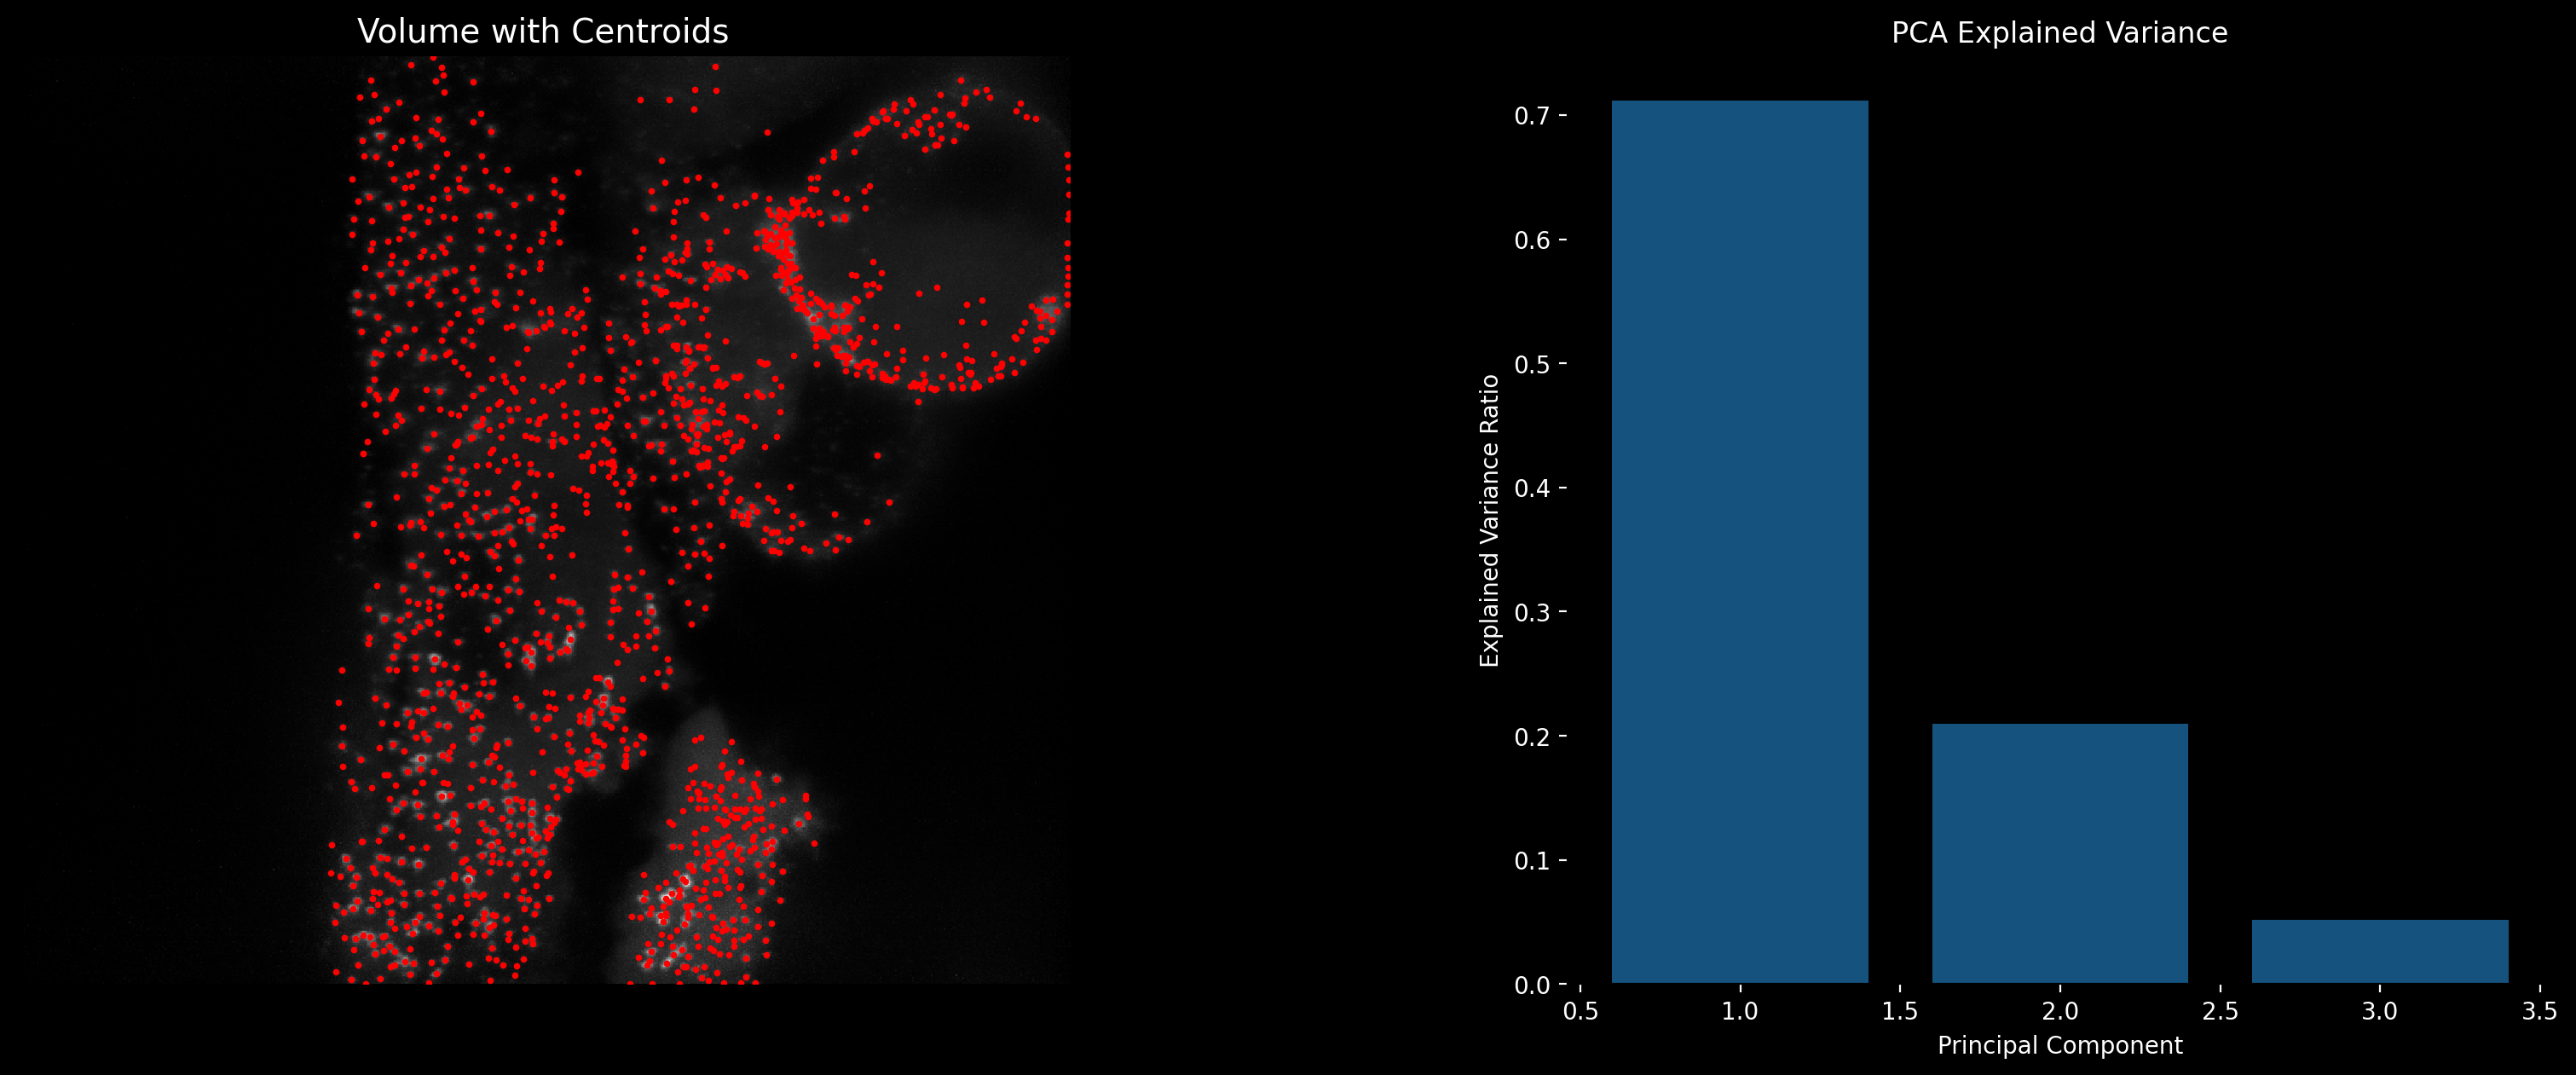

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as skPCA

file_path = file_paths[0]
volume = io.imread(file_path.joinpath("volume.tif"))
centroids = io.imread(file_path.joinpath("centroids.tif"))
features = io.imread(file_path.joinpath("pca_10_res.tif"))
# max_components =
max_components = min(3, features.shape[1])  # Up to 10 or max available
pca_analyzer = skPCA(n_components=max_components)
pca_result = pca_analyzer.fit_transform(features)
explained_variance = pca_analyzer.explained_variance_ratio_

fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 3, figure=fig)  # type: ignore
ax_volume = fig.add_subplot(grid[0, 0:2])
sv = stackview.imshow(volume, plot=ax_volume)
ax_volume.set_title("Volume with Centroids", color="white", fontsize=14)
for i in range(centroids.shape[0]):
    z, y, x = centroids[i]
    ax_volume.scatter(x, y, color="red", s=3)


ax_variance = fig.add_subplot(grid[0, 2])
ax_variance.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
ax_variance.set_xlabel("Principal Component", color="white")
ax_variance.set_ylabel("Explained Variance Ratio", color="white")
ax_variance.set_title("PCA Explained Variance", color="white")

plt.tight_layout()
plt.show()

# Modified Tracking

- `ideas broadly is to get variance weights for each component and multiply them to each component`
- `get trackpy positions and calculate velocity by getting the curret and next time, current and next positon and dividing by that`
- `get average velocity for each component and per volume to use that information`
- `modify the cost matrix to use velocity information`



In [5]:
# generate priors
sampled_pos = sample_centroids(centroids, min_detections)
pred = create_velocity_predictor(sampled_pos)

In [7]:
track_features = get_track_features(
    file_paths=file_paths,  # file_paths,
    config=config,
)
feature_cols = [f"feature_{i}" for i in range(n_components)]
centroid_cols = ["z", "y", "x"]
df = track_features.copy()
df["norm"] = np.linalg.norm(df[feature_cols].to_numpy(), axis=-1)
df = df[df["norm"] > 0.0]
df

Found centroids and features for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0000_488nm_0000000msec_0087860321msecAbs_000x_000y_000z_0000t
Found intensities for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0000_488nm_0000000msec_0087860321msecAbs_000x_000y_000z_0000t
Found centroids and features for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0001_488nm_0003195msec_0087863516msecAbs_000x_000y_000z_0000t
Found intensities for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0001_488nm_0003195msec_0087863516msecAbs_000x_000y_000z_0000t
Found centroids and features for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0002_488nm_0006390msec_0087866711msecAbs_000x_000y_000z_0000t
Found intensities for /nfs/scratch2/shared_image_recog_ml/ap2_unnorm/ex07_CamA_ch0_stack0002_488nm_0006390msec_0087866711msecAbs_000x_000y_000z_0000t
Found centroids and features for /nfs/scratch2/shared_image_recog_m

In [8]:
memory = 100
adaptive_stop = 3.0  # 15.0
search_range = 10.0#15.0  # 25.0
linked = pred.link_df(
    df,
    search_range=search_range,
    adaptive_stop=adaptive_stop,
    adaptive_step=adaptive_step,
    memory=memory,
    pos_columns=centroid_cols + feature_cols,
    t_column="t",
    predictor=pred,
)
linked

Frame 98: 1178 trajectories present.


,z,y,x,t,intensity,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,norm,particle
0,93.872871,342.822754,497.793518,0,54.244526,-2.793550,-128.061111,38.834435,-8.886040,-3.141810,-28.357002,7.189020,-0.134507,1.788656,-2.084802,133.849045,0
1,0.585105,30.665733,259.718658,0,250.199585,-7.753906,-53.831985,-6.938686,9.431273,0.724552,-3.250370,-0.084686,0.796988,-0.508983,-0.130595,54.828377,1
2,1.982368,63.178791,261.366455,0,311.346741,-26.418087,-25.628708,-12.609608,4.768976,0.684965,-1.825535,-0.318593,0.275298,-0.104749,-0.163514,38.906918,2
3,0.346336,92.734726,253.634995,0,239.140167,-4.503361,-58.777206,-5.319408,9.456842,0.766505,-3.168743,-0.000642,0.891283,-0.638848,-0.075732,59.188988,3
4,0.676149,109.152664,258.192596,0,297.895447,-11.175098,-47.343628,-9.602638,10.211309,0.813671,-3.053101,-0.259831,0.779060,-0.479331,-0.094299,49.583393,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186295,165.613724,664.676025,519.294067,98,284.614258,9.839630,5.163643,11.560291,0.672044,1.839757,0.442247,-0.440516,0.120312,-0.142760,0.068184,16.035019,3526
186296,166.473938,678.588257,577.422729,98,223.276306,-28.585014,7.088146,11.360542,0.457447,-0.886036,3.951860,0.508327,0.001327,0.254304,0.029173,31.565910,1228
186297,164.854462,687.135620,571.196899,98,287.947388,-9.226089,-22.561371,4.569221,-3.909330,-1.386406,2.181688,0.325072,0.062625,0.055134,0.000288,24.799475,4263
186298,165.625122,694.556580,518.059204,98,252.008163,3.881271,11.655895,11.776218,3.743373,-0.030066,0.312616,-0.277396,0.176064,-0.236572,0.211124,17.017740,4126


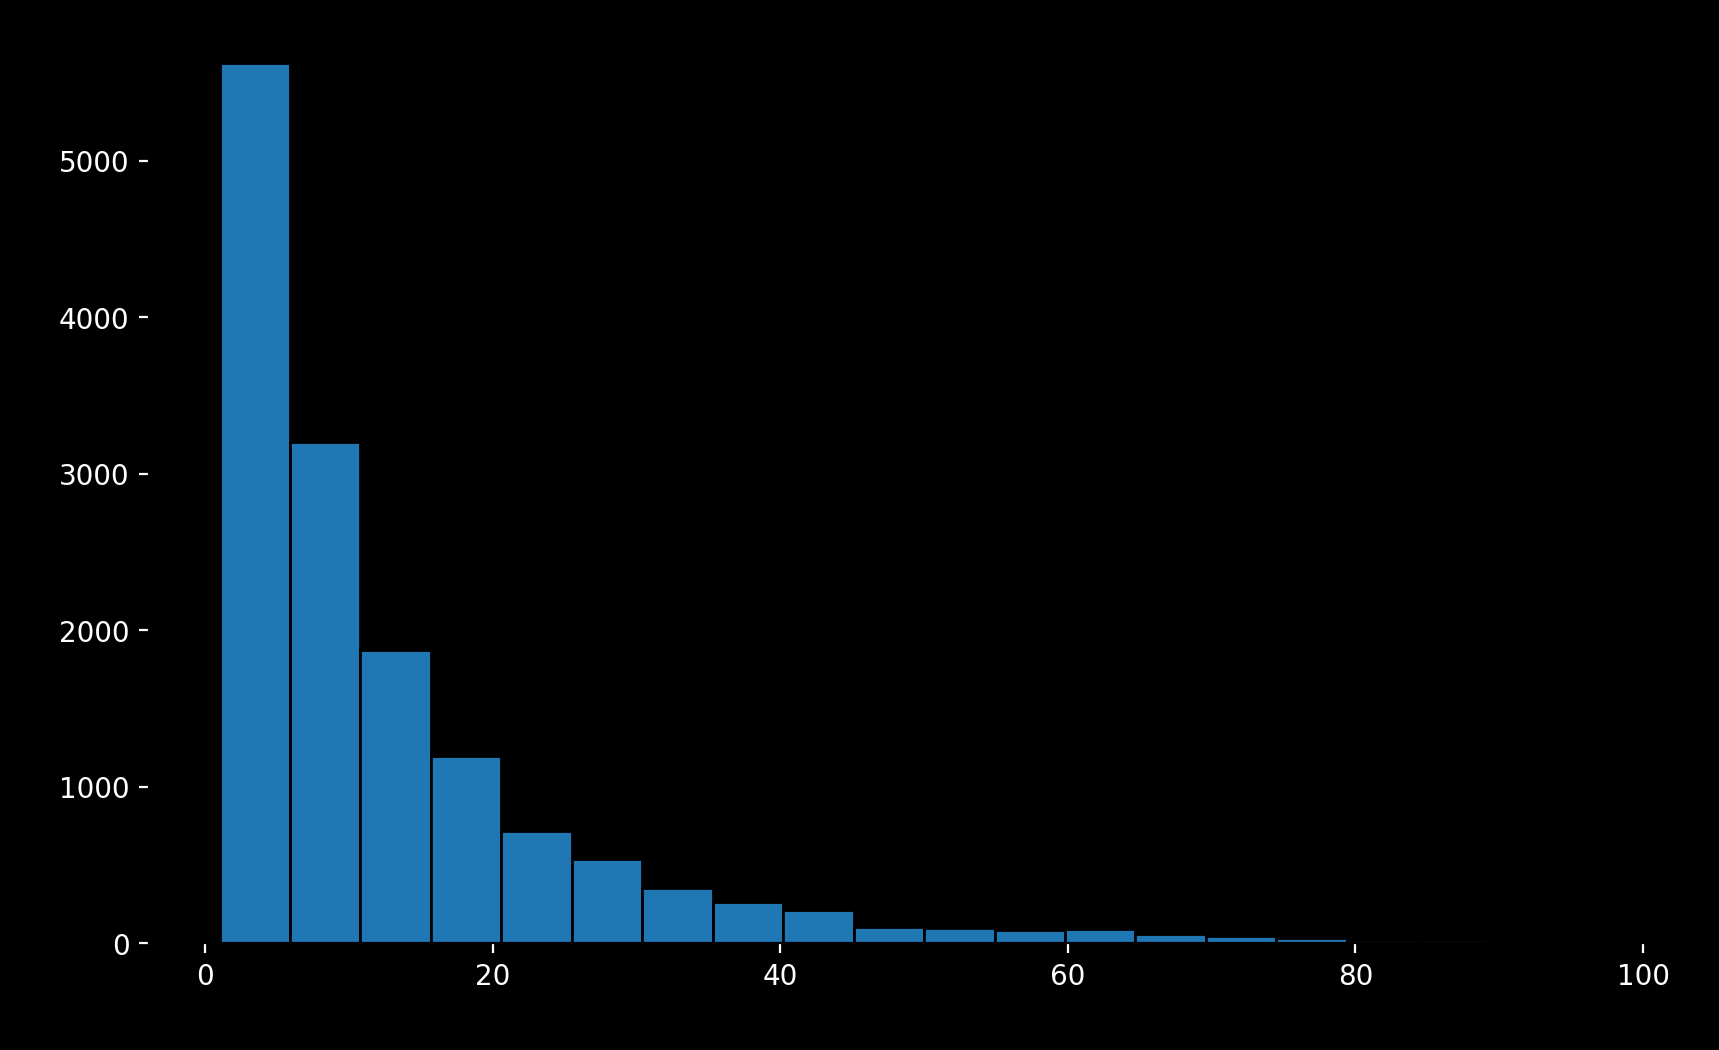

<Figure size 640x480 with 0 Axes>

In [9]:
linked = postprocess_tracking(linked)
plot_particle_freq(linked)

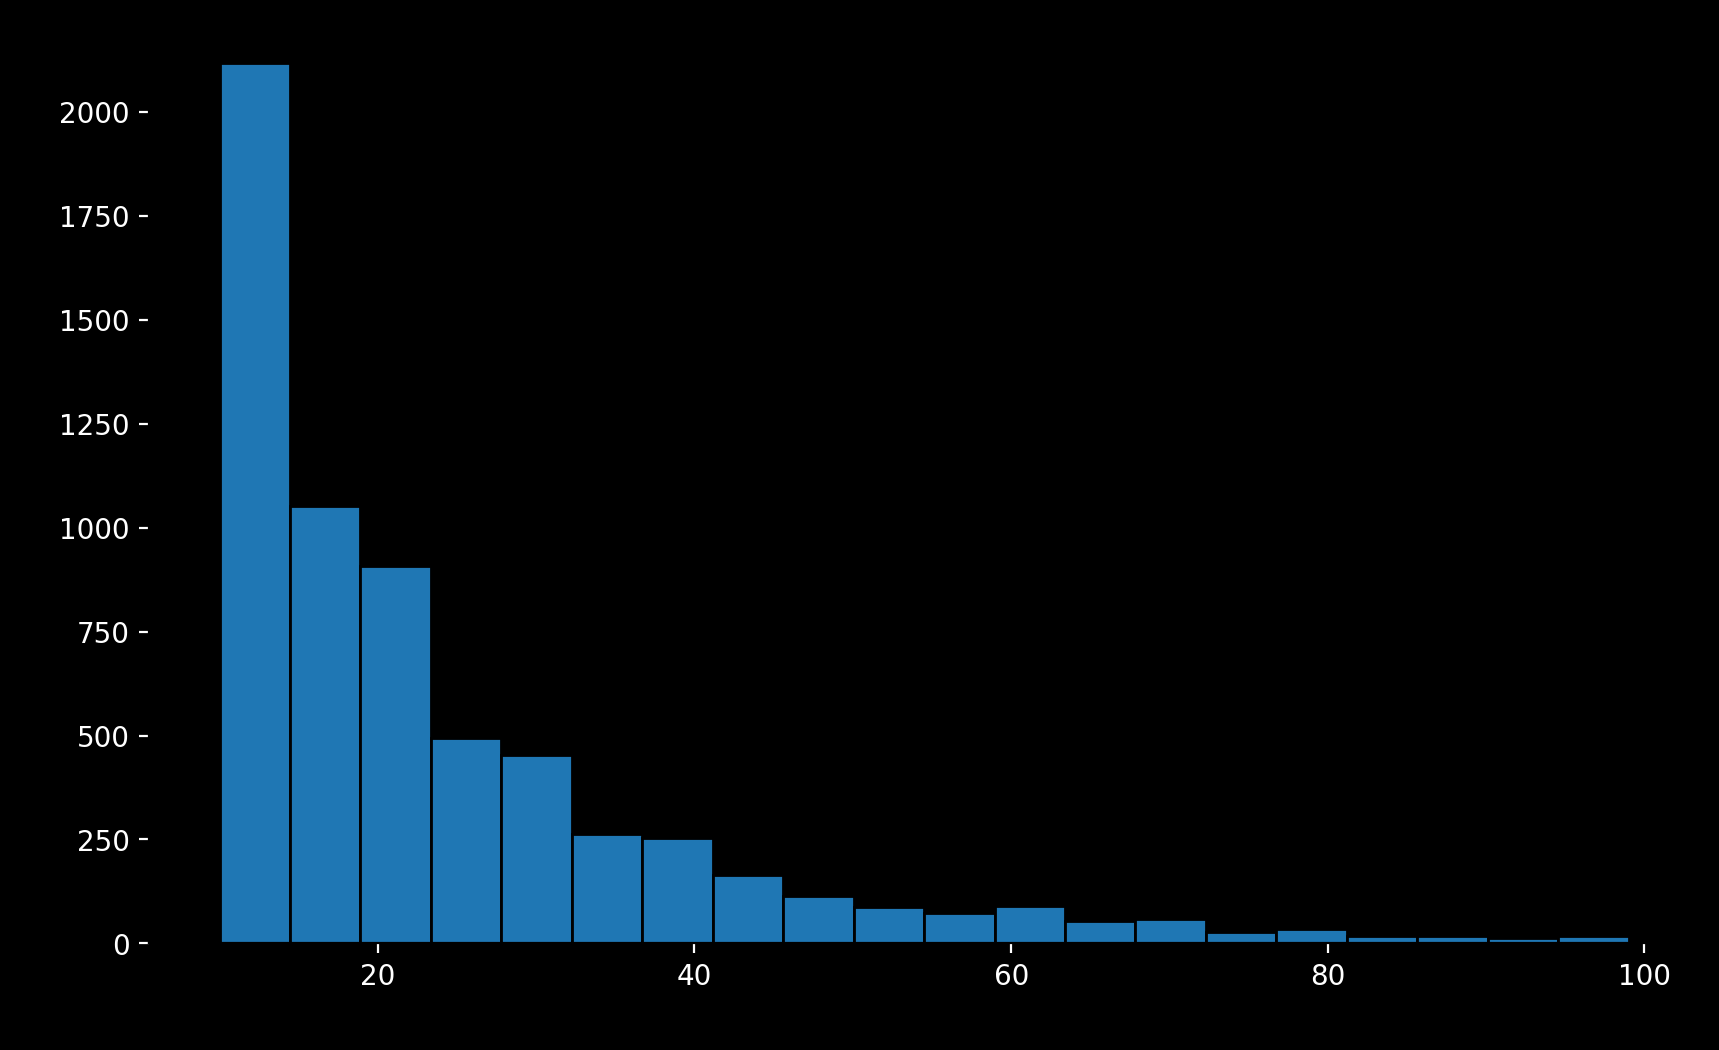

<Figure size 640x480 with 0 Axes>

In [10]:
linked_filtered = filter_tracks(linked, min_length=10)
plot_particle_freq(linked_filtered)

In [11]:
csv_name = "ap2_unnorm"
linked.to_csv(csv_name + ".csv", index=False)